# Examples of the ELO Python Client

## Connect to ELO

In [13]:
from decouple import AutoConfig
from eloservice.elo_service import EloService

config = AutoConfig(search_path='./') # load .env file from current directory with connection details
rest_baseurl = config("TEST_ELO_IX_URL")
rest_user = config("TEST_ELO_IX_USER")
rest_password = config("TEST_ELO_IX_PASSWORD")
elo_service = EloService(url=rest_baseurl, user=rest_user, password=rest_password)

### Load all sales

In [16]:
maskID = "33" #ID of our mask sales
results = elo_service.search(search_mask_id=maskID, max_results=3500)
print(f"found {len(results)} results")

found 2853 results


### Load all sales details

In [17]:
import tqdm
import os
import pickle

# checkout all results
checked_out = []
# restore from pickle if available
if os.path.exists("sales.pkl"):
    with open("sales.pkl", "rb") as f:
        checked_out = pickle.load(f)
        print(f"Restored {len(checked_out)} sales from pickle")
else:
    for result in tqdm.tqdm(results):
        sord = elo_service.checkout(result)
        checked_out.append(sord)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 2853/2853 [01:24<00:00, 33.58it/s]


In [18]:
# store the checked out sords as pickle
with open("sales.pkl", "wb") as f:
    pickle.dump(checked_out, f)
    print(f"Stored {len(checked_out)} sales to pickle on path {os.path.abspath('sales.pkl')}")

Stored 2853 sales to pickle on path /Users/manuel/private_dev/repos/elo-indexserver-client/examples/salesTrendAnalysis/sales.pkl


### We get a bunch of technical sords which we want to filter out.

In [19]:
import re
blacklist = ["Action definition", "sol.*", "trskn.inventory.*"]
cleaned = []
for result in checked_out:
    for black in blacklist:
        if re.match(black, result.name):
            break
    else:
        cleaned.append(result)


In [20]:
cleaned[0].obj_keys

[ObjKey(data=['10100 S18_1749 Online Diecast Creations Co.'], display_data=<eloclient.types.Unset object at 0x106bc5dc0>, id=0, name='SALE_NAME', obj_id=9363, additional_properties={}),
 ObjKey(data=['Vintage Cars'], display_data=<eloclient.types.Unset object at 0x106bc5dc0>, id=1, name='SALE_PRODUCT', obj_id=9363, additional_properties={}),
 ObjKey(data=['3000.00'], display_data=<eloclient.types.Unset object at 0x106bc5dc0>, id=2, name='SALE_AMOUNT', obj_id=9363, additional_properties={}),
 ObjKey(data=['20030106000000'], display_data=<eloclient.types.Unset object at 0x106bc5dc0>, id=3, name='SALE_DATE', obj_id=9363, additional_properties={})]

In [21]:
## convert objkeys to a dict
def objkeys_to_dict(objkeys):
    return {objkey.name: objkey.data[0] if objkey.data else None for objkey in objkeys}

# for each cleaned sord, convert objkeys to a dict
data = [objkeys_to_dict(sord.obj_keys) for sord in cleaned]
data[0]

{'SALE_NAME': '10100 S18_1749 Online Diecast Creations Co.',
 'SALE_PRODUCT': 'Vintage Cars',
 'SALE_AMOUNT': '3000.00',
 'SALE_DATE': '20030106000000'}

In [22]:
# Convert to pandas dataframe
import pandas as pd
df = pd.DataFrame(data)

In [23]:
df

,SALE_NAME,SALE_PRODUCT,SALE_AMOUNT,SALE_DATE
0,10100 S18_1749 Online Diecast Creations Co.,Vintage Cars,3000.00,20030106000000
1,10100 S18_2248 Online Diecast Creations Co.,Vintage Cars,3390.00,20030106000000
2,10100 S18_4409 Online Diecast Creations Co.,Vintage Cars,1903.22,20030106000000
3,10100 S24_3969 Online Diecast Creations Co.,Vintage Cars,1689.03,20030106000000
4,"10101 S18_2325 Blauer See Auto, Co.",Vintage Cars,2500.00,20030109000000
...,...,...,...,...
2822,10425 S50_1392 La Rochelle Gifts,Trucks and Buses,1800.00,20050531000000
2823,Firewall,Infrastructure,400.00,20240310000000
2824,Portait Lizenz - Spesenverwaltung,Portrait License,1000.00,20240315000000
2825,Portrait Lizenz,Portrait License,800.00,20240318000000


In [24]:
# convert SALE_AMOUNT to float
df["SALE_AMOUNT"] = df["SALE_AMOUNT"].astype(float)
# convert SALE_DATE to datetime
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"])

df

,SALE_NAME,SALE_PRODUCT,SALE_AMOUNT,SALE_DATE
0,10100 S18_1749 Online Diecast Creations Co.,Vintage Cars,3000.00,2003-01-06
1,10100 S18_2248 Online Diecast Creations Co.,Vintage Cars,3390.00,2003-01-06
2,10100 S18_4409 Online Diecast Creations Co.,Vintage Cars,1903.22,2003-01-06
3,10100 S24_3969 Online Diecast Creations Co.,Vintage Cars,1689.03,2003-01-06
4,"10101 S18_2325 Blauer See Auto, Co.",Vintage Cars,2500.00,2003-01-09
...,...,...,...,...
2822,10425 S50_1392 La Rochelle Gifts,Trucks and Buses,1800.00,2005-05-31
2823,Firewall,Infrastructure,400.00,2024-03-10
2824,Portait Lizenz - Spesenverwaltung,Portrait License,1000.00,2024-03-15
2825,Portrait Lizenz,Portrait License,800.00,2024-03-18


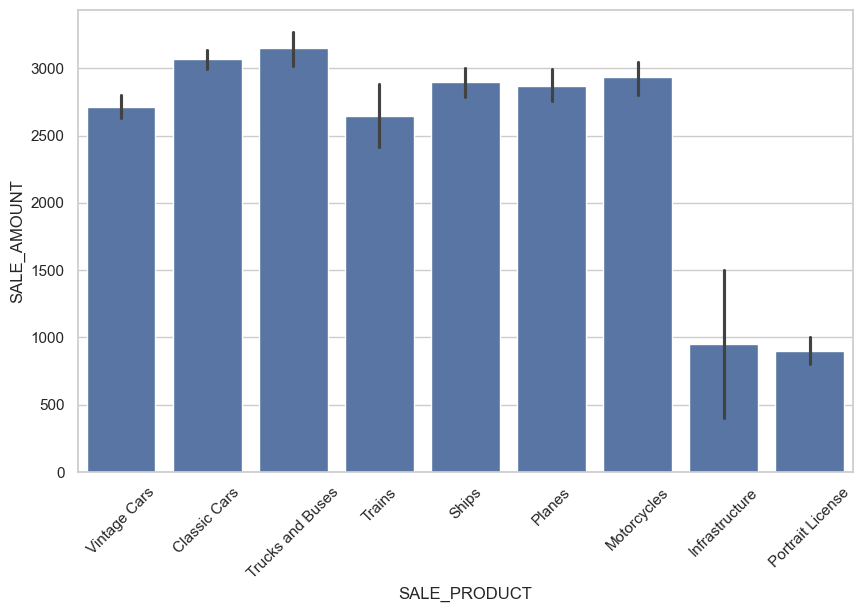

In [25]:
# generate a chart with seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="SALE_PRODUCT", y="SALE_AMOUNT", data=df, estimator="mean")
plt.xticks(rotation=45)
plt.savefig("sales.png", dpi=300, bbox_inches="tight")
plt.show()

## use reportlab to generate a PDF with the sale statistics chart and table

In [26]:
import io
import reportlab as rl
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph
from reportlab.lib.styles import getSampleStyleSheet


# create a buffer
buffer = io.BytesIO()
# create a PDF
doc = SimpleDocTemplate(buffer, pagesize=letter)
stylesheet=getSampleStyleSheet()
elements = []
# add a title
elements.append(Paragraph("Sales Statistics", style=stylesheet['Title']))
elements.append(rl.platypus.Spacer(1, 12))

# create a table
data = [df.columns[:,].tolist()] + df.values.tolist()
table = Table(data)
# add style
style = TableStyle([('BACKGROUND', (0, 0), (-1, 0), rl.lib.colors.grey),
                    ('TEXTCOLOR', (0, 0), (-1, 0), rl.lib.colors.whitesmoke),
                    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
                    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
                    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
                    ('BACKGROUND', (0, 1), (-1, -1), rl.lib.colors.beige),
                    ('GRID', (0, 0), (-1, -1), 1, rl.lib.colors.black)])
table.setStyle(style)
# add table to the PDF
elements.extend([table, rl.platypus.Spacer(1, 12)])

# add sales.png to the PDF
from reportlab.lib.pagesizes import letter
from reportlab.platypus import Image
img = Image("sales.png", 5*rl.lib.units.inch, 3*rl.lib.units.inch)
elements.append(img)

# add some space
elements.append(rl.platypus.Spacer(1, 12))

# add a barcode
from reportlab.graphics.barcode import code39
from reportlab.graphics.shapes import Drawing
bc = code39.Extended39("1234567890", barWidth=0.5*rl.lib.units.mm, barHeight=15*rl.lib.units.mm)
elements.append(bc)

doc.build(elements)
# get the PDF as a byte string
pdf = buffer.getvalue()
buffer.close()

# save the PDF to a file
with open("sales.pdf", "wb") as f:
    f.write(pdf)
    